# 1. 代码实现

In [2]:
import torch
import d2l_torch as d2l
from torch import nn
from torch.nn import functional as F

## 1.1 残差结构定义

In [14]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        """
        Args:
        input_channels:输入通道数
        num_channels：输出通道数
        use_1x1conv:是否使用1x1卷积（是的话，表明通道数改变，不是的话，就没改变，残差连接中不加入1x1卷积）
        stride：默认给1，因为不改变通道个数的那种residual block用的比较多
        """
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)  # 默认情况下，resnet block中第一个卷积层大小不变
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1) # 而第二个卷积层一直是不变的
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)  
        else:
            self.conv3=None
        self.bn1=nn.BatchNorm2d(num_channels)   
        self.bn2=nn.BatchNorm2d(num_channels)
        self.relu=nn.ReLU(inplace=True)  
        # inplace: can optionally do the operation in-place  
        # 直接在原地进行relu操作（对relu的上一层输出的结果直接修改，不会保留原始值了），节省内存
    
    def forward(self,X):
        """
        注意，上面定义组件/网络层的顺序无所谓，关键是下面的网络计算顺序对就可以了
        虽然残差块可以有不同的结构，但是这里实现的时候，使用原始的结构
        """
        Y=self.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X  
        return self.relu(Y) 

从residual block的实现就可以看到：
+ conv1的结构和conv3是一样的，即conv1+conv2的结果的维度，其实和conv3是一样的（输出的大小以及通道个数，都是一样的）
+ bn层只是一种操作层，和maxpool这些一样，所以没必要定义两个一样的bn层（bn1和bn2），等会使用的时候，改改网络结构，看用一样的和用两个会有什么区别吗？个人感觉应该是没有区别的，又没有要学习的参数，只是一个类似加减的操作而已。**TBD**
    + 而且这里relu虽然也在两个地方使用，但是使用的是同一个定义。。。（所以真没必要）
+ 弹幕里有人问，**如果我strides=2，并且不需要1x1卷积层，那不是会导致X和Y形状不一致，然后相加报错吗**，
    + 这个代码写的确实没那么严格，又不是pytorch框架自带的代码，需要写很多异常控制语句。
+ 根据：pytorch的forum的讨论：[Add Residual connection](https://discuss.pytorch.org/t/add-residual-connection/20148)
    + 结合我之前看到过使用resnet网络作为backbone的情况，这个东西pytorch确实没有现成的实现，要靠自己去手动写一个，但是也不难。

## 1.2 验证输出维度

In [11]:
blk=Residual(3,3) # 默认不加1x1卷积的  stride=1  padding=1 kernel_size=3 两个卷积层
X=torch.rand((4,3,6,6))  #可以认为是batch_size=4， 4张大小为6x6的彩色图
Y=blk(X)
print(f"输入X的维度为：{X.shape}\n输出Y的维度为：{Y.shape}")

输入X的维度为：torch.Size([4, 3, 6, 6])
输出Y的维度为：torch.Size([4, 3, 6, 6])


**注意，这里能够计算得到Y，说明已经对blk进行默认初始化过了，不然是没法计算的**

**输入输出通道个数不同，则需要进行如下调用**

In [15]:
blk=Residual(3,6,use_1x1conv=True,strides=2)  # 高宽减半，通道加倍。
Y=blk(X)
print(f"输入X的维度为：{X.shape}\n输出Y的维度为：{Y.shape}")

输入X的维度为：torch.Size([4, 3, 6, 6])
输出Y的维度为：torch.Size([4, 6, 3, 3])


确实是高宽减半，通道加倍

## 1.3 实现ResNet18

In [4]:
# stage1的实现
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

# 后面4个残差块结构都差不多，定义一个，然后传参就可以
def residual_block(input_channels,output_channels,num_residuals,first_block=False):
    blk=[]
    for i in range(num_residuals):  
        # 下面i=0判断是不是这个stage中第一个residual block，
        # first_block其实名字起的不好，它其实是想表示第一个residual block的第一个卷积层是否是有通道数变化的
        if i==0 and not first_block: # 后续含有残差块的stage，基本都是第一个块是有通道数改变的，后面是没有的
            blk.append(Residual(input_channels,output_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(output_channels,output_channels))
    return blk

b2=nn.Sequential(*residual_block(64,64,2,first_block=True))
b3=nn.Sequential(*residual_block(64,128,2))
b4=nn.Sequential(*residual_block(128,256,2))
b5=nn.Sequential(*residual_block(256,512,2))

resnet=nn.Sequential(b1,b2,b3,b4,b5,
                     nn.AdaptiveAvgPool2d((1,1)),
                     nn.Flatten(),nn.Linear(512,10)) 
# nn.Linear(512*7*7,1000) 正常resnet18最后一层应该是这样的，这里为了简便测试，就改成这样了。
# 输入是32，经过5次减半，就是1（32/2/2/2/2/2=1），也就是b5输出的通道/feature map大小为1，通道数为512，要进行的是10分类
# 在之前的GoogLeNet中，也是5个stage(但是不是严格的每个stage高宽减半，通道加倍)，最后一层是net=nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

查看每层的输出维度

In [29]:
X=torch.rand((1,1,214,214))
for layer in resnet:
    X=layer(X)
    print(f"{layer.__class__.__name__} output shape:{X.shape}") 

Sequential output shape:torch.Size([1, 64, 54, 54])
Sequential output shape:torch.Size([1, 64, 54, 54])
Sequential output shape:torch.Size([1, 128, 27, 27])
Sequential output shape:torch.Size([1, 256, 14, 14])
Sequential output shape:torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:torch.Size([1, 512, 1, 1])
Flatten output shape:torch.Size([1, 512])
Linear output shape:torch.Size([1, 10])


注意，如果输入的X维度是(1,1,32,32)，就会在stage5报错，输入的feature map<1，所以设计的时候要注意计算的合理性。

## 1.4 训练模型

VGG的时候，resize是224，GoogLeNet和这个，都是resize成96，不然训练时间会很久。

loss 0.009, train acc 0.998, test acc 0.926
800.6 examples/sec on cuda:0


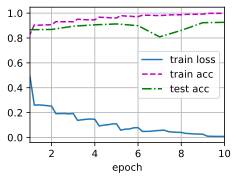

In [32]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) 
d2l.train_ch6(resnet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 2. 对比实验

## 2.1 一个bn层定义

In [3]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        """
        Args:
        input_channels:输入通道数
        num_channels：输出通道数
        use_1x1conv:是否使用1x1卷积（是的话，表明通道数改变，不是的话，就没改变，残差连接中不加入1x1卷积）
        stride：默认给1，因为不改变通道个数的那种residual block用的比较多
        """
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)  # 默认情况下，resnet block中第一个卷积层大小不变
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1) # 而第二个卷积层一直是不变的
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)  
        else:
            self.conv3=None
        self.bn=nn.BatchNorm2d(num_channels)   
        self.relu=nn.ReLU(inplace=True)  
        # inplace: can optionally do the operation in-place  
        # 直接在原地进行relu操作（对relu的上一层输出的结果直接修改，不会保留原始值了），节省内存
    
    def forward(self,X):
        """
        注意，上面定义组件/网络层的顺序无所谓，关键是下面的网络计算顺序对就可以了
        虽然残差块可以有不同的结构，但是这里实现的时候，使用原始的结构
        """
        Y=self.relu(self.bn(self.conv1(X)))
        Y=self.bn(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X  
        return self.relu(Y) 

其余代码和上面一样，运行上面的就行，但是为了对比结果，所以把绘图训练部分重新放在下面了

loss 0.018, train acc 0.995, test acc 0.395
803.0 examples/sec on cuda:0


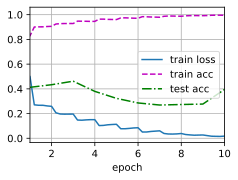

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) 
d2l.train_ch6(resnet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 2.1-1 查看BN层参数

In [6]:
print(resnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (2): Sequential(
    (0): Residual(
      (conv1): Co

In [11]:
resnet[1][0]

Residual(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [16]:
resnet[1][0].state_dict()['bn.weight']

tensor([1.0053, 0.9776, 1.0130, 1.0011, 0.9836, 1.0024, 0.9827, 0.9898, 1.0089,
        1.0000, 1.0005, 1.0031, 0.9959, 1.0091, 0.9917, 0.9937, 1.0283, 0.9830,
        0.9802, 1.0009, 1.0036, 0.9967, 0.9903, 1.0074, 0.9966, 0.9986, 1.0054,
        0.9933, 0.9923, 1.0019, 0.9964, 1.0111, 1.0168, 0.9976, 1.0097, 0.9896,
        0.9934, 0.9957, 0.9812, 1.0051, 0.9931, 1.0200, 0.9959, 0.9797, 0.9993,
        0.9985, 0.9898, 0.9938, 1.0160, 0.9923, 1.0033, 1.0004, 0.9952, 1.0044,
        0.9968, 0.9849, 0.9873, 1.0099, 1.0080, 1.0026, 0.9896, 0.9914, 0.9845,
        0.9944], device='cuda:0')

In [17]:
resnet[1][0].state_dict()['bn.bias']

tensor([-0.0086, -0.0118, -0.0090, -0.0117, -0.0105, -0.0055,  0.0090,  0.0089,
        -0.0077, -0.0096, -0.0016,  0.0079, -0.0015, -0.0035, -0.0021, -0.0127,
        -0.0095, -0.0045, -0.0093, -0.0111,  0.0036,  0.0070, -0.0163, -0.0056,
         0.0064,  0.0031, -0.0064, -0.0026, -0.0093, -0.0026, -0.0073, -0.0105,
         0.0035, -0.0109,  0.0044, -0.0134, -0.0071, -0.0001, -0.0115, -0.0117,
        -0.0086, -0.0120,  0.0104, -0.0156, -0.0057, -0.0082, -0.0094, -0.0016,
        -0.0048, -0.0082,  0.0020,  0.0061, -0.0114, -0.0059, -0.0082, -0.0093,
        -0.0212, -0.0090, -0.0134,  0.0026, -0.0160, -0.0208, -0.0067, -0.0165],
       device='cuda:0')

In [18]:
resnet[1][0].state_dict()['bn.bias'].shape

torch.Size([64])

所以BN层是有权重的。。。。（以前一直觉得没有，而且这里的权重和偏置，刚好就等于那个特征数（作用于卷积层就是通道数））

## 2.2 BN层不进行参数估计，直接使用评估的BN

In [19]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        """
        Args:
        input_channels:输入通道数
        num_channels：输出通道数
        use_1x1conv:是否使用1x1卷积（是的话，表明通道数改变，不是的话，就没改变，残差连接中不加入1x1卷积）
        stride：默认给1，因为不改变通道个数的那种residual block用的比较多
        """
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)  # 默认情况下，resnet block中第一个卷积层大小不变
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1) # 而第二个卷积层一直是不变的
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)  
        else:
            self.conv3=None
        self.bn=nn.BatchNorm2d(num_channels,track_running_stats=False)   
        self.relu=nn.ReLU(inplace=True)  
        # inplace: can optionally do the operation in-place  
        # 直接在原地进行relu操作（对relu的上一层输出的结果直接修改，不会保留原始值了），节省内存
    
    def forward(self,X):
        """
        注意，上面定义组件/网络层的顺序无所谓，关键是下面的网络计算顺序对就可以了
        虽然残差块可以有不同的结构，但是这里实现的时候，使用原始的结构
        """
        Y=self.relu(self.bn(self.conv1(X)))
        Y=self.bn(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X  
        return self.relu(Y) 

loss 0.010, train acc 0.998, test acc 0.336
804.9 examples/sec on cuda:0


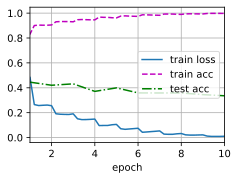

In [20]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) 
d2l.train_ch6(resnet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())